# take2

**GOAL**: Keep It Stupid Simple = KISS.

**Dependencies:**
 - [pocketknives](https://github.com/zjwilliams20/pocketknives)

**References:**
 1. [ilqgames/python](https://github.com/HJReachability/ilqgames/blob/master/python)

In [1]:
%load_ext autoreload
%autoreload 1
%aimport decentralized.control2, decentralized.dynamics2, decentralized.cost2

In [2]:
import functools
import itertools
import random
from time import perf_counter as pc

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.spatial.transform import Rotation
import torch

from decentralized import control2, dynamics2, cost2, compute_pairwise_distance, split_agents
import pocketknives

π = np.pi

In [3]:
%matplotlib widget
plt.rcParams['axes.grid'] = True

<Figure size 640x480 with 0 Axes>

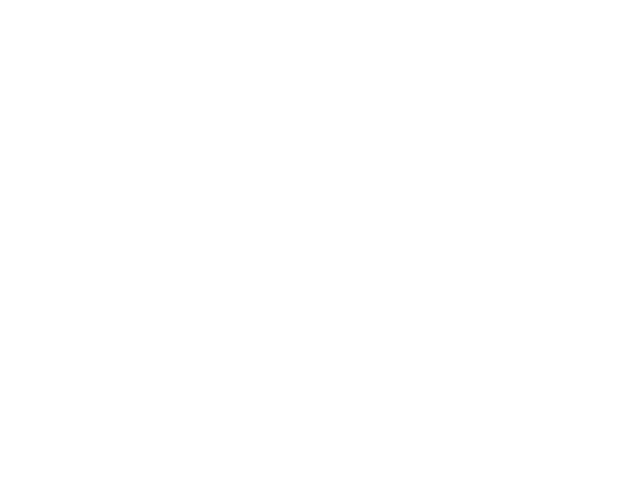

In [25]:
plt.figure()

In [11]:
def pos_mask(x_dims):
    """Return a mask that's true wherever there's an x or y position""" 
    return np.array([i % x_dims[0] < 2 for i in range(sum(x_dims))])

In [12]:
def plot_solve(X, J, x_goal, x_dims=None):
    """Plot the resultant trajectory on plt.gcf()"""

    plt.clf()
    
    if not x_dims:
        x_dims = [X.shape[1]]
        
    N = X.shape[0]
    t = np.arange(N) * dt
    
    X_split = split_agents(X, x_dims)
    x_goal_split = split_agents(x_goal.reshape(1,-1), x_dims)
    
    for Xi, xg in zip(X_split, x_goal_split):
        plt.scatter(Xi[:,0], Xi[:,1], c=t)
        plt.scatter(Xi[0,0], Xi[0,1], 80, 'g', 'x', label="$x_0$")
        plt.scatter(xg[0,0], xg[0,1], 80, 'r', 'x', label="$x_f$")
    
    plt.margins(0.1)
    plt.title(f"Final Cost: {J:.3g}")

## single-agent problem

In [13]:
def reference_cost(x, u, _x_goal, _Q, _R, _Qf=None, terminal=False):
    """Cost of reaching the goal"""
    
    assert isinstance(x, torch.Tensor) and isinstance(u, torch.Tensor)
    x = x.reshape(-1,1)
    u = u.reshape(-1,1)
    
    if _Qf is None:
        _Qf = torch.eye(_Q.shape[0])
    
    if terminal:
        return (x - _x_goal).T @ _Qf @ (x - _x_goal)
    return (x - _x_goal).T @ _Q @ (x - _x_goal) + u.T @ _R @ u

In [93]:
class UnicycleDynamics(dynamics2.AutoDiffModel):
    @staticmethod
    def f(x, u):
        mm = torch if torch.is_tensor(x) else np
        return mm.stack([
            x[3] * mm.cos(x[2]),
            x[3] * mm.sin(x[2]),
            u[0],
            u[1]
        ])

In [94]:
dt = 0.1
N = 50

x = torch.tensor([-10, 10, 0, 0], dtype=torch.float, requires_grad=True)
x_goal = torch.zeros((4, 1), dtype=torch.float)

dynamics = UnicycleDynamics(4, 2, dt)

Q = torch.diag(torch.tensor([1., 1, 0, 0]))
Qf = 1000 * torch.eye(Q.shape[0])
R = torch.eye(2)
cost = cost2.ReferenceCost(x_goal, Q, R, Qf)

ilqr = control2.iLQR(dynamics, cost, x.numel(), 2, dt, N)
X, U, J = ilqr.solve(x)
plot_solve(X, J, x_goal.numpy())

0/50	J: 210000


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

## multi-agent problem

### initializing the scene
Here, we define some initial positions within some distance of each other, and then rotate them about the origin by some random angle to hopefully create some interesting scenarios.

In [95]:
def randomize_locs(n_pts, min_sep=3.0, var=3.0, n_dim=2):
    """Uniformly randomize locations of points in N-D while enforcing
       a minimum separation between them.
    """ 
    
    # Distance to move away from center if we're too close.
    Δ = 0.1 * n_pts
    x = var * np.random.uniform(-1, 1, (n_pts, n_dim))
    
    # Determine the pair-wise indicies for an arbitrary number of agents.
    pair_inds = np.array(list(itertools.combinations(range(n_pts), 2)))
    move_inds = np.arange(n_pts)

    # Keep moving points away from center until we satisfy radius
    while move_inds.size:
        center = np.mean(x, axis=0)
        distances = compute_pairwise_distance(x.flatten(), [n_dim]*n_pts)

        move_inds = pair_inds[distances.flatten() <= min_sep]
        x[move_inds] += Δ * (x[move_inds] - center)
    
    return x

In [96]:
def face_goal(x0, x_goal):
    """Make the agents face the direction of their goal with a little noise"""
    
    VAR = 0.01
    dX = x_goal[:,:2] - x0[:,:2]
    headings = np.arctan2(*np.rot90(dX, 1))
    
    x0[:,2] = headings + VAR * np.random.randn(x0.shape[0])
    x_goal[:,2] = headings + VAR * np.random.randn(x0.shape[0])
    
    return x0, x_goal

In [97]:
def randy_setup():
    """Hardcoded example with reasonable consistency eyeballed from 
       Potential-iLQR paper
    """
    x0 = torch.tensor([[0.5, 1.5, 0.1, 0,
                        2.5, 1.5, π, 0,
                        1.5, 1.3, π/2, 0]], 
                     dtype=torch.float, requires_grad=True).T
    x_goal = torch.tensor([[2.5, 1.5, 0, 0, 
                            0.5, 1.5, π, 0, 
                            1.5, 2.2, π/2, 0]]).T
    return x0, x_goal

To be consistent between simulations, we normalize for the scale of the setup by computing the *energy*, or the sum of distances from the origin of the points. This should be the same for all runs.

In [98]:
def compute_energy(x, x_dims):
    """Determine the sum of distances from the origin"""
    return torch.sum(x[pos_mask(x_dims)].reshape(-1,2).norm(dim=1)).item()

def normalize_energy(x, x_dims, energy=10.0):
    """Zero-center the coordinates and then ensure the sum of 
       squared distances == energy
    """
    
    # Don't mutate x's data for this function, keep it pure.
    x = x.clone()
    n_agents = len(x_dims)
    center = x[pos_mask(x_dims)].reshape(-1, 2).mean(0)

    with torch.no_grad():
        x[pos_mask(x_dims)] -= center.tile(n_agents).reshape(-1,1)
        x[pos_mask(x_dims)] *= energy / compute_energy(x, x_dims)
    assert x.numel() == sum(x_dims)
    
    return x

def perturb_state(x, x_dims, var=0.5):
    """Add a little noise to the start to knock off perfect symmetries"""
    
    x = x.clone()
    with torch.no_grad():
        x[pos_mask(x_dims)] += var*torch.randn_like(x[pos_mask(x_dims)])
    
    return x

In [99]:
def random_setup(n_agents, **kwargs):
    """Create a randomized set up of initial and final positions"""
    
    # Rotate the initial points by some amount about the center.
    theta = π + random.uniform(-π/4, π/4)
    R = Rotation.from_euler('z', theta).as_matrix()[:2, :2]

    # We don't have to normlize for energy here
    x_i = randomize_locs(n_agents, **kwargs)
    x_f = x_i @ R + x_i.mean(axis=0)
    # x_f = randomize_locs(n_agents, 3.0)

    x0 = np.c_[x_i, np.zeros((n_agents, 2))]
    x_goal = np.c_[x_f, np.zeros((n_agents, 2))]
    x0, x_goal = face_goal(x0, x_goal)
    
    x0 = torch.from_numpy(x0).requires_grad_(True).type(torch.float)
    x_goal = torch.from_numpy(x_goal).type(torch.float)
    
    return x0.reshape(-1,1), x_goal.reshape(-1,1)

In [100]:
n_agents = 3
sep_init = 1.0
# x0, x_goal = random_setup(n_agents, min_sep=sep_init, var=1.0)
x0, x_goal = randy_setup()

x_dims = [4] * n_agents
u_dims = [2] * n_agents
x0 = normalize_energy(x0, x_dims)
x_goal = normalize_energy(x_goal, x_dims)

# x0 = perturb_state(x0, x_dims)

plt.clf()
plt.gca().set_aspect('equal')
X = torch.dstack([
    x0.reshape(n_agents, 4).detach(), 
    x_goal.reshape(n_agents, 4).detach()
]).swapaxes(1,2)
for i, Xi in enumerate(X):
    plt.annotate('', Xi[1,:2], Xi[0,:2], 
                 arrowprops=dict(facecolor=plt.cm.tab20.colors[2*i]))
pocketknives.set_bounds(X.reshape(-1,4), zoom=0.2)

In [128]:
dt = 0.05
N = 50
tol = 1e-3

dynamics_12d = dynamics2.MultiDynamicalModel([UnicycleDynamics(4, 2, dt)] * n_agents)

Q = 4 * torch.diag(torch.tensor([1., 1, 0, 0]).tile(n_agents))
# Qf = 1000 * torch.eye(Q.shape[0])
Qf = 1000 * torch.diag(torch.tensor([1., 1, 0, 1]).tile(n_agents))
R = torch.eye(2*n_agents)

radius = 1.0

# DBG
Q = Q.numpy()
Qf = Qf.numpy()
R = R.numpy()

goal_cost = cost2.ReferenceCost(x_goal.detach(), Q, R, Qf)
prox_cost = cost2.ProximityCost(x_dims, radius)
game_cost = cost2.GameCost(goal_cost, prox_cost)

In [129]:
%%time
# %%prun
ilqr = control2.iLQR(dynamics_12d, game_cost, x0.numel(), 2*n_agents, dt, N)
t0 = pc()
X, U, J = ilqr.solve(x0.detach().numpy(), tol=tol)

# t_solve = pc() - t0
# with open('out.log', 'a') as file:
#     file.write(f"{type(ilqr)}\t{t_solve=:.8g}\t{J=:.8g}\n")

TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'

In [125]:
%debug

> /home/zjw/miniconda3/envs/take2/lib/python3.9/site-packages/torch/_tensor.py(732)__array__()
    730             return handle_torch_function(Tensor.__array__, (self,), self, dtype=dtype)
    731         if dtype is None:
--> 732             return self.numpy()
    733         else:
    734             return self.numpy().astype(dtype, copy=False)



ipdb>  u


> /home/zjw/documents/grad/Research/decentralized/decentralized/cost2.py(148)__call__()
    146         if not terminal:
    147             return (x - self.xf) @ self.Q @ (x - self.xf).T + u @ self.R @ u.T
--> 148         return (x - self.xf) @ self.Qf @ (x - self.xf).T
    149 
    150 



ipdb>  x


tensor([-4.6778,  0.3119,  0.1000,  0.0000,  4.6778,  0.3119,  3.1416,  0.0000,
         0.0000, -0.6237,  1.5708,  0.0000], dtype=torch.float64,
       requires_grad=True)


ipdb>  self.xf


array([[ 3.9676406, -0.9257824,  0.       ,  0.       , -3.9676406,
        -0.9257824,  3.1415927,  0.       ,  0.       ,  1.8515662,
         1.5707964,  0.       ]], dtype=float32)


ipdb>  x - self.xf


*** RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.


ipdb>  q


In [118]:
plot_solve(X, J, x_goal.numpy(), x_dims)

In [119]:
plt.clf()
plt.plot(compute_pairwise_distance(X, x_dims).T)
plt.hlines(radius, *plt.xlim(), 'r', ls='--')

In [120]:
costs = []
for xi, ui in zip(X, U):
    costs.append(game_cost(torch.from_numpy(xi), torch.from_numpy(ui)).item())
plt.clf()
plt.plot(costs)

In [38]:
def setup(X, x_goal, x_dims, radius):
    plt.clf()
    
    n_agents = len(x_dims)
    ax = plt.gca()
    handles = []
    for i in range(n_agents):
        handles.append((
            plt.plot(0, c=plt.cm.tab20.colors[2*i], marker='o', markersize=4)[0],
            ax.add_artist(plt.Circle(np.nan, radius, color='k', fill=True, alpha=0.3, lw=2))
        ))
        
    for xg in split_agents(x_goal, x_dims):
        plt.scatter(xg[0,0], xg[0,1], c='r', marker='x', zorder=10)

    X_cat = np.vstack(split_agents(X, x_dims))
    pocketknives.set_bounds(X_cat, zoom=0.3)
    
    return handles
    
def animate(t, handles, X, x_dims, x_goal):
    """Animate the solution into a gif"""
    for (i, xi), hi in zip(enumerate(split_agents(X, x_dims)), handles):
        hi[0].set_xdata(xi[:t,0])
        hi[0].set_ydata(xi[:t,1])
        hi[1].set_center(xi[t-1,:2])
    

In [39]:
plt.clf()
handles = setup(X, x_goal.flatten(), x_dims, radius)
animate(-1, handles, X, x_dims, x_goal)

In [106]:
handles = setup(X, x_goal.flatten(), x_dims, radius)
anim = FuncAnimation(plt.gcf(), animate, frames=N+1, fargs=(handles, X, x_dims, x_goal))
anim.save('traj.gif', fps=5)

MovieWriter ffmpeg unavailable; using Pillow instead.
